In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

In [4]:
path = 'data/mnist/'

In [5]:
import os
os.makedirs(path, exist_ok=True)

In [6]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [7]:
# get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [8]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

### Normalize

In [9]:
mean = x.mean()
std = x.std()

In [10]:
x = (x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.30728981, -3.1638146e-07, 0.99999934)

In [11]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

### Plot helpers

In [12]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [13]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

### Plots

In [14]:
x_valid.shape

(10000, 784)

In [15]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

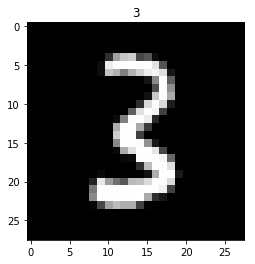

In [16]:
show(x_imgs[0], y_valid[0])

In [17]:
y_valid.shape

(10000,)

In [18]:
y_valid[0]

3

In [19]:
x_imgs[0, 10:15, 10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

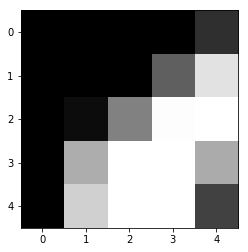

In [20]:
show(x_imgs[0, 10:15, 10:15])

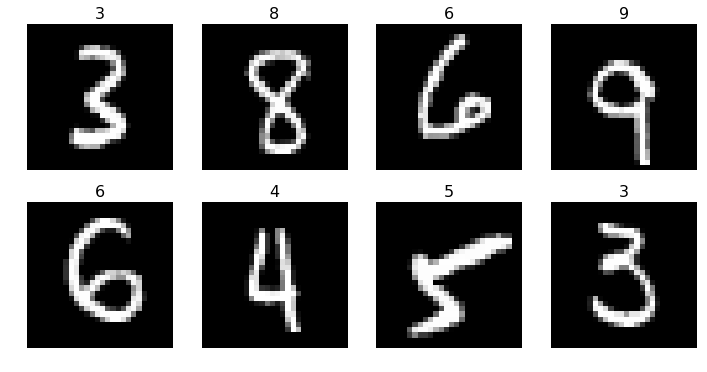

In [21]:
plots(x_imgs[:8], titles = y_valid[:8])

In [22]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

In [23]:
net = nn.Sequential(
    nn.Linear(28*28,100),
    nn.ReLU(),
    nn.Linear(100,10),
    nn.LogSoftmax()
).cuda()

In [24]:
md = ImageClassifierData.from_arrays(path,(x,y),(x_valid,y_valid))

In [25]:
x.shape

(50000, 784)

In [26]:
loss = nn.NLLLoss()
metrics = [accuracy]
opt = optim.Adam(net.parameters())

### Fitting the model

In [27]:
fit(net,md,epochs=1, crit=loss, opt=opt, metrics=metrics)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.170609   0.161667   0.954319  



[0.16166709, 0.95431926751592355]

In [28]:
def binary_loss(y,p):
    return np.mean(-(y*np.log(p) + (1-y)*np.log(1-p)))

In [29]:
acts = np.array([1,0,0,1])
preds = np.array([0.9,0.1,0.2,0.8])
binary_loss(acts,preds)

0.164252033486018

In [30]:
preds = predict(net, md.val_dl)

In [31]:
preds.shape

(10000, 10)

In [32]:
preds.argmax(axis=1)[:5]

array([3, 8, 6, 9, 6])

In [33]:
preds = preds.argmax(1)

In [34]:
np.mean(preds == y_valid)

0.95409999999999995

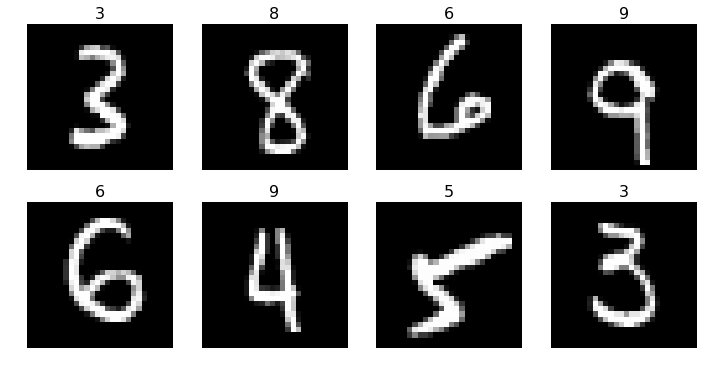

In [35]:
plots(x_imgs[:8],titles=preds[:8])

## Defining Logistic Regression Ourselves

In [36]:
torch.randn(3,4).cuda()*3


 2.7749 -2.8950  0.2388  3.6173
-0.7470  1.6296  0.5429 -1.0122
-1.4356  6.3884  2.2485 -6.8187
[torch.cuda.FloatTensor of size 3x4 (GPU 0)]

In [37]:
def get_weights(dims): return nn.Parameter(torch.randn(dims)/dims[0])

In [38]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights([28*28,10])
        self.l1_b = get_weights([10])
        
    def forward(self,x):
        x = x.view(x.size(0),-1)
        x = torch.matmul(x, self.l1_w) + self.l1_b
        x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=0)))
        return x

In [39]:
net2 = LogReg().cuda()
opt = optim.Adam(net2.parameters())

In [40]:
fit(net2, md, epochs=1, crit = loss, opt=opt, metrics=metrics) 

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      2.443207   2.393973   0.909037  



[2.3939729, 0.9090366242038217]

In [41]:
dl = iter(md.trn_dl)

In [42]:
xmb,ymb = next(dl)

In [43]:
vxmb = Variable(xmb.cuda())
vxmb

Variable containing:
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
          ...             ⋱             ...          
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
[torch.cuda.FloatTensor of size 64x784 (GPU 0)]

In [44]:
preds = net2(vxmb).exp(); preds[:3]

Variable containing:

Columns 0 to 5 
 1.2069e-03  1.8887e-05  4.9174e-03  6.5119e-03  1.7728e-04  5.9566e-03
 2.4510e-03  5.8937e-05  2.6070e-04  1.3363e-02  4.3908e-04  2.4366e-01
 3.3933e-04  1.3680e-07  2.5470e-05  1.3685e-04  1.2993e-02  8.5835e-06

Columns 6 to 9 
 2.1048e-01  6.2066e-07  8.9761e-04  1.3054e-05
 7.4563e-04  5.4921e-05  4.6790e-03  4.0578e-04
 1.7373e-05  4.9294e-03  5.9304e-03  2.8847e-01
[torch.cuda.FloatTensor of size 3x10 (GPU 0)]

In [45]:
preds.max(1)[1]

Variable containing:
 6
 5
 9
 0
 3
 1
 7
 7
 7
 2
 4
 4
 1
 4
 0
 5
 1
 5
 6
 3
 4
 8
 9
 9
 1
 5
 1
 2
 8
 0
 6
 6
 0
 1
 7
 3
 7
 0
 2
 3
 4
 6
 8
 2
 5
 9
 0
 1
 2
 2
 7
 7
 8
 0
 8
 7
 3
 2
 4
 7
 4
 3
 0
 8
[torch.cuda.LongTensor of size 64 (GPU 0)]

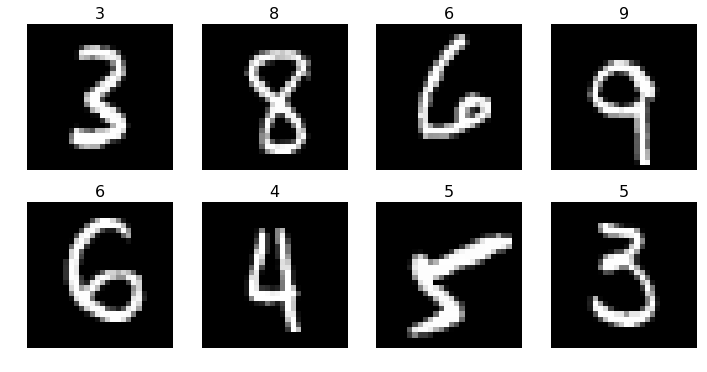

In [46]:
preds = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds[:8])

In [58]:
a = np.array([10,6,-4])
b = np.array([2,8,7])
a,b

(array([10,  6, -4]), array([2, 8, 7]))

In [59]:
a+b

array([12, 14,  3])

In [61]:
(a<b)*a

array([ 0,  6, -4])

In [62]:
a

array([10,  6, -4])

In [63]:
a>0

array([ True,  True, False], dtype=bool)

In [64]:
a+1

array([11,  7, -3])

In [65]:
m = np.array([[1,2,3],[4,5,6],[7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [66]:
2*m

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [67]:
c = np.array([10,20,30]);c

array([10, 20, 30])

In [68]:
m+c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [69]:
c+m

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [70]:
c.shape

(3,)

In [71]:
np.expand_dims(c,0).shape

(1, 3)

In [73]:
np.expand_dims(c,1)

array([[10],
       [20],
       [30]])

In [74]:
m + np.expand_dims(c,1)

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [76]:
c[None,:,None].shape

(1, 3, 1)

In [77]:
np.broadcast_to(c, m.shape)

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [79]:
np.broadcast_to(c[:,None], m.shape)

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

In [81]:
c[None] > c[:, None]

array([[False,  True,  True],
       [False, False,  True],
       [False, False, False]], dtype=bool)

In [82]:
xg,yg = np.ogrid[0:5,0:5];xg,yg

(array([[0],
        [1],
        [2],
        [3],
        [4]]), array([[0, 1, 2, 3, 4]]))

In [83]:
m,c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]), array([10, 20, 30]))

In [84]:
m@c

array([140, 320, 500])

In [86]:
torch.from_numpy(m) @ torch.from_numpy(c


 140
 320
 500
[torch.LongTensor of size 3]

In [87]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights([28*28,10])
        self.l1_b = get_weights([10])
        
    def forward(self,x):
        x = x.view(x.size(0),-1)
        x = torch.matmul(x, self.l1_w) + self.l1_b
        x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=0)))
        return x
    
net2 = LogReg().cuda()
opt = optim.Adam(net2.parameters())

fit(net2, md, epochs=1, crit = loss, opt=opt, metrics=metrics) 

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      2.43155    2.395327   0.910529  



[2.3953273, 0.91052945859872614]

In [88]:
net2 = LogReg().cuda()
loss = nn.NLLLoss()
learning_rate = 1e-3
optimizer = optim.Adam(net2.parameters(),lr = learning_rate)

In [89]:
dl = iter(md.trn_dl) # data loader

In [92]:
xt,yt = next(dl)
y_pred = net2(Variable(xt).cuda())

In [93]:
l = loss(y_pred, Variable(yt).cuda())
print(l)

Variable containing:
 4.1563
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [94]:
optimizer.zero_grad()
l.backward()
optimizer.step()

In [95]:
xt,yt = next(dl)
y_pred = net2(Variable(xt).cuda())

In [96]:
l = loss(y_pred, Variable(yt).cuda())
print(l)

Variable containing:
 4.0334
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [97]:
for t in range(100):
    xt,yt = next(dl)
    y_pred = net2(Variable(xt).cuda())
    l = loss(y_pred, Variable(yt).cuda())

    if t%10 ==0:
        accuracy = np.mean(to_np(y_pred).argmax(axis=1)==to_np(yt))
        print("loss: ", l.data[0], "\t accuracy: ", accuracy)
        
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

loss:  4.050480365753174 	 accuracy:  0.515625
loss:  3.0795962810516357 	 accuracy:  0.828125
loss:  2.796804428100586 	 accuracy:  0.84375
loss:  2.7224507331848145 	 accuracy:  0.828125
loss:  2.5798492431640625 	 accuracy:  0.9375
loss:  2.5331883430480957 	 accuracy:  0.921875
loss:  2.4670870304107666 	 accuracy:  0.921875
loss:  2.5730056762695312 	 accuracy:  0.90625
loss:  2.623748302459717 	 accuracy:  0.796875
loss:  2.4854071140289307 	 accuracy:  0.90625
